# 3 Usefulness
## 3.1 Predictive Model Performance
1. The original and synthetic evaluation samples are further divided into a test sample (90% of evaluation sample) and train sample (10% of evaluation sample). Categorical columns are one-hot-encoded, so all datas are numbers.  
2. A series of $ N $ commonly used predictive models (Random Forests, Linear Regression…) are trained on the train samples for both the real and the synthetic data and applied to the test samples. Suppose there are _n_ columns, the predictive model attempts to predict each column based on the rest _(n-1)_ of the columns. For different tasks, TSTR or TSTS & TRTR is applied.
    * TSTR: we calculate the error $ e_{i} $ (in this code we use MSE) for each column $ i $,  calculate the -- see _section II._
    $$
    E = \frac { \sum_{i=1}^{n} e_{i}}{n} 
    $$
        The lower the _E_, the better the synthetic data.
        
    * TSTS & TRTR: we calculate the error $ e_{i,j} $ (real) and $ e'_{i,j} $ (synthetic) for each column _i_ and predictive model _j_. There are two ways to compare TSTS and TRTR:      
        * We want to see if a model performs better than another model on the real data, whether or not it performs better on the synthetic data as well. We calculate $ E_{j} $ and $ E'_{j} $ for every model $ j $ and use a measuring quantity called $ SRA $ (Synthetic Ranking agreement) between lists $ (E)_{j=1}^{N} $ and $ (E')_{j=1}^{N} $  . SRA measures the proportion of agreed ranking, the higher the SRA, the better the synthetic data.  (see 1.3 for detailed explanation of SRA) -- see _section III._
       
        * We can also use SRA to measure the list of $ (e)_{i=1}^{n} $ for each column predicition results, for the specified model and synthetic data generator. -- see _section IV._
        * We want to see for a model $ j $, whether they generate similar error or not. We work 
        $$
        \epsilon _{j} = \sum_{i=1}^{n} (e_{i,j}-e'_{i,j})^2, 
        $$ 
          the lower the quantity, the better the synthetic data. -- see _section V._
          
* How to deal with 'NaN'?
    * For categorical columns which proportion of NaN in is significant (e.g. over 10%), treating NaN values as a category.
    * For columns which proportion of NaN in is insignificant, deleting samples with an NaN in such columns.
    * For numerical columns which proportion of NaN in is significant, fill NaN with 0. (Luckily we don't have too many such columns in the PRISM dataset and it makes sense to do so)

## Possible Improvements of the code
The code spends too much time on running every model (especially SVM and KNN) on each column, but when it comes to _E_, /epsilon, SRA actually we don't need to run the model fit things again (which is what this version of code does but actually very ineffective.) Now it takes nearly one hour to run through the whole code and it's getting my MacBook really hot.

## I. Import and Pre-Process the data

In [1]:
import numpy as np
import pandas as pd
dp_ori_df = pd.read_csv('synthetic data/doppelGANger/dp_ori.csv') #originally ori_features_prism.npy
dp_gen_df = pd.read_csv('synthetic data/doppelGANger/dp_gen.csv') #originally features_600.npy
tgan_ori_df = pd.read_csv('synthetic data/TGAN/tgan_ori.csv') #originally cat_time_10visits_all_noid.csv
tgan_gen_df = pd.read_csv('synthetic data/TGAN/tgan_gen.csv') #originally gen_cat_time_10visits_wl_5000it.npy
ori_df = pd.read_csv('synthetic data/2_no_id/ori_df.csv') #originally cat_time_5abovevisits_all.csv
gen_1_df = pd.read_csv('synthetic data/2_no_id/gen_1_df.csv') #originally gen_cat_time_10visits_wl_5000it_hd10_nl5.npy
gen_2_df = pd.read_csv('synthetic data/2_no_id/gen_2_df.csv') #originally gen_cat_time_10visits_wl_5000it_hd10.npy
gen_3_df = pd.read_csv('synthetic data/2_no_id/gen_3_df.csv') #originally gen_dop_cat_5abovevisits_d2g_e449.npy
gen_4_df = pd.read_csv('synthetic data/2_no_id/gen_4_df.csv') #originally from gen_cat_time_10visits_all_5000it.npy.
dp_0827_df = pd.read_csv('synthetic data/2_no_id/dp_0827_gen.csv')  #originally gen_doptf2_cat_5abovevisits_e200_lstm.csv
# all in 2d

In [5]:
#remove all-zero rows, as lots of trivial all-zero rows can bias the result heavily
#Only dp_ have lots of padded zeros
dp_ori_nozero = dp_ori_df[np.any(abs(dp_ori_df)!=0,axis=1)].copy()
dp_gen_nozero = dp_gen_df[np.any(abs(dp_gen_df)!=0,axis=1)].copy()

In [8]:
#keep numerical variables only
tgan_ori_num = tgan_ori_df.iloc[:,:6].dropna()
tgan_gen_num = tgan_gen_df.iloc[:,:6].dropna()
ori_num = ori_df.iloc[:,:6].dropna()
gen_1_num = gen_1_df.iloc[:,:6].dropna()
gen_2_num = gen_2_df.iloc[:,:6].dropna()
gen_3_num = gen_3_df.iloc[:,:6].dropna()
gen_4_num = gen_4_df.iloc[:,:6].dropna()
gen_4_num = gen_4_df.iloc[:,:6].dropna()
dp_0827_num = dp_0827_df.iloc[:,:6].dropna()

In [10]:
#Set up a dictionary for furture loop
synthetic_num_dic = {'DoppelGANger_0814':[dp_ori_nozero,dp_gen_nozero],'DoppelGANger_0824':[ori_num,gen_3_num],'DoppelGANger_0827':[ori_num,dp_0827_num],\
                     'tGAN':[tgan_ori_num,tgan_gen_num],\
                      'tGAN 1':[tgan_ori_num,gen_1_num],'tGAN 2':[tgan_ori_num,gen_2_num],\
                      'tGAN 4':[tgan_ori_num,gen_4_num]}
syn_keys = list(synthetic_num_dic.keys())
n = len(syn_keys)

In [11]:
def SRA(R,S):
    '''Calculate the SRA
    
    Args:
    - R: A list of values (e.g. performance metrics of different predictive models) from TSTS
    - S: A list of values (e.g. performance metrics of different predictive models) from TRTR, len(S)=len(R)
    
    Returns:
    - SRA: SRA value
    
    '''
    def identity_function(statement):
        v = 0
        if statement:
            v = 1
        return v
            
    k = len(R)
    sum_ = 0
    for i in range(k):
        for j in range(k):
            if i != j:
                if (R[i]-R[j])==0:
                    if (S[i]-S[j])==0:
                        agree = True
                    else:
                        agree = False
                else:
                    agree = (R[i]-R[j])*(S[i]-S[j])>0
                sum_ += identity_function(agree)
    SRA = sum_ / (k*(k-1))
    return SRA

In [12]:
def DataDivide(data,rate=0.75):
    import numpy as np
    """divides the dataset to two sets, after random permutation of samples 
  
  Args:
    - data: original data
    - rate: the volumn of the first set/ the volumn of the original dataset
    
  Returns:
    - data1: the first dataset after division
    - data2: the second dataset
  """
    no = len(data)
    idx = np.random.permutation(no)
    idx1 = idx[:int(no*rate)]
    idx2 = idx[int(no*rate):]
    
    if type(data)==np.ndarray:
        data1 = data[idx1]
        data2 = data[idx2]
    else:
        data1 = data.iloc[idx1,:]
        data2 = data.iloc[idx2,:]
    
    return data1, data2

In [13]:
class Prediction:
    def __init__(self,df,df2=None):
        import numpy as np
        import pandas as pd
        if type(df2) != pd.core.frame.DataFrame: 
            #so the class is suitable for both TSTR and TSTS&TRTR purpose depending on how many dataframs are initialised. 
            #If there is only one 'df', then it will carry on training on this df and testing on this df;
            #If there is another 'df2', then it will train on df and test on df2, so this is for TSTR purporse
            self.df_train, self.df_test = DataDivide(df)
        else:
            self.df_train, _1= DataDivide(df)
            _2, self.df_test = DataDivide(df2)
        self.keys = (df.keys()).tolist()

    def ColumnPrepare(self,column_name):
        #We want to predict column 'column_name' from other columns, so X is values from other columns,
        #y is values from column 'column_name'; _train variables are used to train models (supervised learning),
        #_test variables are used to test models
        keys = self.keys.copy()
        keys.remove(column_name)
        keys_removed = keys
        
        X_train = self.df_train[keys_removed].values
        y_train = self.df_train[column_name].values
        X_test = self.df_test[keys_removed].values
        y_test = self.df_test[column_name].values
        return X_train, y_train, X_test, y_test
    
    def PredictionColumnWise(self,method):
        from sklearn.linear_model import LinearRegression
        from sklearn.tree import DecisionTreeRegressor
        from sklearn.svm import LinearSVR
        from sklearn.ensemble import RandomForestRegressor
        from sklearn.neighbors import KNeighborsRegressor
        '''
        Train predictive models specified by 'method' arg to predict each column from other columns
        Args:
        method: ='LR','DTR','SVM','RFR', refering to different predictive models
        
        Returns: dataframe consisting of y_test (label) and y_predict (predicted results) for each column
        '''
        name_index_1 = []
        name_index_2 = ['y_test','y_pred']*len(self.keys)
        first = True
        for column_name in self.keys:
            X_train, y_train, X_test, y_test = self.ColumnPrepare(column_name)
            
            if method == 'LR':
                reg = LinearRegression()
            if method == 'DTR':
                reg = DecisionTreeRegressor()
            if method == 'SVM':   
                reg = LinearSVR()
            if method == 'RFR':
                reg = RandomForestRegressor()
            if method == 'KNR1':
                reg = KNeighborsRegressor(radius = 1)
            if method == 'KNR5':
                reg = KNeighborsRegressor(radius = 5)
            reg.fit(X_train, y_train)    
            y_pred = reg.predict(X_test)
            value_temp = np.concatenate((y_test[:,np.newaxis],y_pred[:,np.newaxis]),axis = 1)
            value_temp = value_temp.T
            
            if first:
                value = value_temp
                first = False
            else:
                value = np.concatenate((value,value_temp),axis = 0)
            name_index_1 += [column_name]*2
        index = pd.MultiIndex.from_arrays([name_index_1,name_index_2])
        return pd.DataFrame(value.T, columns = index )
    
    def Evaluation_MSE(self,method,aver = False):
        '''
        Args:
        method: ='LR','DTR','SVM','RFR', refering to different predictive models
        
        Returns:
        The User can choose to return a series of MSEs for each column by leaving aver == False, 
        if aver == True, then the return is the 'E' i.e. average of MSEs for each column
        '''
        
        from sklearn.metrics import mean_squared_error
        Presult = self.PredictionColumnWise(method)
        n = len(self.keys)
        MSE = np.array([0.5]*n)
        k=0
        for column_name in self.keys:
            y_pred = Presult[column_name]['y_pred']
            y_test = Presult[column_name]['y_test']
            MSE[k] = mean_squared_error(y_pred, y_test)
            k+=1
        MSE_series = pd.Series(MSE, index = self.keys) # The e_i's for every column
        E = np.sum(MSE_series)/len(MSE_series) # The 'E' for this model
        if aver:
            return E
        else:
            return pd.Series(MSE, index = self.keys)

In [14]:
def Comparison_Table(df_dic,models = ['LR','DTR','SVM','RFR','KNR1','KNR5']):
    '''
    The dataframe values are E's for the index model which is trained and tested on the dataset in that column.
    '''
    keys = list(df_dic.keys())
    v_np = np.zeros((len(models),len(keys)*2))
    keys_index= []
    for k in keys:
        keys_index += [k]*2
    type_index = ['ori','gen']*len(keys)
    column_multi = np.array([keys_index,type_index])
    column_multi = pd.MultiIndex.from_arrays(column_multi)
    display ('average MSE for each model and dataset')
    
    for i in range(len(keys)):
        key = keys[i]
        ori = df_dic[key][0]
        gen = df_dic[key][1]
        PO = Prediction(ori)
        PG = Prediction(gen)
        for j in range(len(models)):
            model = models[j]
            v_np[j][i*2] = PO.Evaluation_MSE(model,aver = True)
            v_np[j][i*2+1] = PG.Evaluation_MSE(model,aver = True)
    np.save('v_np.npy',v_np)
    return pd.DataFrame(v_np,index = models, columns = column_multi)
            
    

## II. Table of E values for the specified model and synthetic generator when TSTR applied

In [15]:
def TSTR(df_dic,models = ['LR','DTR','SVM','RFR','KNR1','KNR5'],ColumnWise=False ):
    keys = list(df_dic.keys())
    l = len(keys)
    data_name = []
    column_name = []
    if ColumnWise:
        for n in range(l):
            key = keys[n]
            ori = df_dic[key][0]
            gen = df_dic[key][1]
            P = Prediction(gen,df2 = ori)
            for m in range(len(models)):
                model = models[m]
                v_Series = P.Evaluation_MSE(model)
                v_value = v_Series.values
                v_value = np.reshape(v_value,(1,len(v_value)))
                v_df = pd.DataFrame(v_value,columns = list(v_Series.index))
                v_df['model'] = model
                if m==0:
                    v_df_con = v_df.copy()
                else:
                    v_df_con = pd.concat([v_df_con,v_df],ignore_index = True)
            v_df_con = v_df_con.set_index('model')
            data_col = (v_df_con.keys()).tolist()
            column_name += data_col
            data_name += [key]*len(data_col)
            if n==0:
                v_df_all = v_df_con.copy()
            else:
                v_df_all = pd.concat([v_df_con, v_df_all],axis = 1)
        multi_array = np.array([data_name,column_name])
        col_multi = pd.MultiIndex.from_arrays(multi_array)
        v_df_final = pd.DataFrame(v_df_all.values,index = models, columns = col_multi)
        return v_df_final
    else:
        keys = list(df_dic.keys())
        l = len(keys)
        v_np = np.zeros((len(models),l))
        for n in range(l):
            key = keys[n]
            ori = df_dic[key][0]
            gen = df_dic[key][1]
            P = Prediction(gen,df2 = ori)
            for m in range(len(models)):
                model = models[m]
                v_np[m][n] = P.Evaluation_MSE(model,aver = True)
        return pd.DataFrame(v_np,index = models, columns = keys)

In [16]:
TSTR_table = TSTR(synthetic_num_dic,ColumnWise=True)

/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

### IITSTR_table.csv Explanation
The values are the MSE of the result from the certain column using model in the index, data in the column with TSTR applied. This certain column is the one to be predicted using other columns.

The meaning of TSTR is not as significant as TSTS vs TRTR for the PRISM dataset, but we can make it useful by  

* Comparing it with TSTS and TRTR tables

_Be careful! Small MSE value here may not mean good prediction, it might just because the distribution of data in this column has very small variance (see 'age' column for exmaple)_

In [17]:
display(TSTR_table)
TSTR_table.to_csv('csv_results/3.1 DWP/IITSTR_table.csv')

DoppelGANger_0814                                               \
                  dday       weight      height       age      temp   
LR         1599.751877  6495.340315  821.508828  5.330293  0.060153   
DTR         705.136941    69.001325  132.147635  2.431232  0.055783   
SVM         748.124158  5743.287784  570.824322  8.096994  0.060668   
RFR         702.775072    64.773658   88.587101  2.873820  0.055638   
KNR1        742.136098   105.121031  324.158450  2.248185  0.057471   
KNR5        742.136098   105.121031  324.158450  2.248185  0.057471   

     DoppelGANger_0824                                                   ...  \
                  dday       height       weight        temp  vomit_dur  ...   
LR            3.273332  2165.849485  3882.223909  562.107910   7.705224  ...   
DTR           1.096170  1572.952684    69.039186   76.341908   0.297177  ...   
SVM           1.119731  1318.561214  3382.333861  329.553424  10.622725  ...   
RFR           1.095922  1513.941009    60.891411   66.623901   0.290505  ...   
KNR1          1.295543  1335.177338   208.983537  107.719709   0.996453  ...   
KNR5          1.295543  1335.177338   208.983537  107.719709   0.996453  ...   

          tGAN 2                                    tGAN 4               \
          weight        temp vomit_dur cough_dur      dday       height   
LR    253.612156  146.770630  1.070586  0.070479  1.552513  1908.143346   
DTR   323.920520  152.561508  4.326326  0.079361  3.443316  4330.345714   
SVM   328.912934  189.250070  2.565285  0.070700  1.598375  1991.244015   
RFR   130.299817   96.357125  2.535283  0.072161  2.071620  2299.453983   
KNR1  121.620217   99.380312  1.582387  0.072307  1.877372  2555.713177   
KNR5  121.620217   99.380312  1.582387  0.072307  1.877372  2555.713177   

                                                    
          weight        temp   vomit_dur cough_dur  
LR    111.352273  188.711660   97.704193  0.546674  
DTR   294.235661  283.524156  136.609041  2.224905  
SVM   684.376378  179.303027  222.304122  8.323993  
RFR   141.444460  107.505399  104.500833  0.955974  
KNR1  177.834570  123.204901  110.342123  1.195906  
KNR5  177.834570  123.204901  110.342123  1.195906  

[6 rows x 41 columns]

In [18]:
TSTR_E_table = TSTR(synthetic_num_dic,ColumnWise=False)

/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

### IITSTR_table.csv Explanation
The values are the average MSE over all columns in this data of the DWP result using model in the index, data in the column with TSTR applied. 

In [19]:
display(TSTR_E_table)
TSTR_E_table.to_csv('csv_results/3.1 DWP/IITSTR_E_table.csv')

,DoppelGANger_0814,DoppelGANger_0824,DoppelGANger_0827,tGAN,tGAN 1,tGAN 2,tGAN 4
LR,431.338649,1882.235765,4855.413065,1510.627723,2454.121523,1104.136745,1141.199790
DTR,1002.781890,11284.268325,2421.576901,182.162744,270.936190,202.938251,160.869144
SVM,491.952349,1425.278224,2347.517094,663.699995,738.947316,530.144014,1284.232892
RFR,493.415850,5252.826592,1791.731488,174.435024,265.117812,194.389408,154.300867
KNR1,566.206015,4491.061485,3244.255213,218.158984,189.975954,194.640634,213.442306
KNR5,566.206015,4491.061485,3244.255213,218.158984,189.975954,194.640634,213.442306


### Example: Display the result of TSTR
We take the DoppelGANger_0814 pair using Linear regression method as an example, to present the predicted value _'y_pred'_ and real value _'y_test'_.

In [20]:
from sklearn.metrics import mean_squared_error
dp_P = Prediction(synthetic_num_dic['DoppelGANger_0814'][0],df2 = synthetic_num_dic['DoppelGANger_0814'][1])
LR_dp_result = dp_P.PredictionColumnWise('LR')
LR_dp_result.to_csv('csv_results/3.1 DWP/LR_dp0814_TSTR_example.csv')
display(LR_dp_result)

dday                weight                 height              \
           y_test     y_pred     y_test     y_pred      y_test      y_pred   
0      104.349383  37.527866  10.737683  19.003179  112.512152   99.074294   
1       38.405182  46.157058  10.541145  10.961335   93.353696  104.092257   
2       30.650574  43.992070  28.810710  26.195994  119.444753  124.445469   
3       27.616518  55.274445  73.399432  64.374529  191.468621  182.908676   
4       12.606098  32.647205  15.131536   5.443927   78.559170  100.740616   
...           ...        ...        ...        ...         ...         ...   
11885   60.332370  42.862356  35.894433  15.876256   99.925661  129.456923   
11886   67.832340  38.379380   2.861520 -10.423105   35.456682   92.481626   
11887  -45.342204  29.346355  16.744232  21.141593  117.978538  100.363191   
11888  136.397027  47.773649  66.204229  45.478313  149.961959  169.348007   
11889  -14.286577  27.424887   8.237421  12.360537   96.640910   90.258178   

             age                  temp             
          y_test     y_pred     y_test     y_pred  
0       1.426491   3.066539  36.785179  37.098342  
1       1.000571   2.309209  32.855589  37.218398  
2      12.449388  14.360840  35.690856  37.092957  
3      36.540238  47.249120  35.593794  36.753193  
4       0.569130   1.047492  38.920550  37.299467  
...          ...        ...        ...        ...  
11885   5.486184  15.836295  36.632545  37.180789  
11886   1.193269  -9.079872  34.878417  37.438354  
11887   2.907052   5.559675  40.900605  37.162986  
11888  27.745679  37.861205  37.745029  36.883067  
11889   0.902317  -1.485585  40.730466  37.234508  

[11890 rows x 10 columns]

A scatter plot of the 'weight' column in the above table.

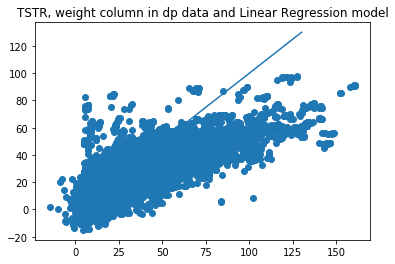

In [21]:
import matplotlib.pyplot as plt
plt.scatter(LR_dp_result['weight']['y_test'], LR_dp_result['weight']['y_pred'])
plt.plot([0,130],[0,130])
plt.title('TSTR, weight column in dp data and Linear Regression model')
plt.savefig('png_files/3.1 DWP/TSTR_weight_dp0814_LR.png')
plt.show()


## III. E Table
Table of $ E $ values for Linear Regression, Decision Tree Regression, Linear SVM and Random Forests models for real and synthetic data from DoppelGANger and TGANs.

In [22]:
com_t = Comparison_Table(synthetic_num_dic)
display(com_t)

'average MSE for each model and dataset'

/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

DoppelGANger_0814             DoppelGANger_0824               \
                   ori         gen               ori          gen   
LR          414.744908  574.425582       1350.120043  2321.806092   
DTR         787.949617  749.203958       2266.938109  2341.938247   
SVM         448.259875  666.033766       1382.661502  2704.468582   
RFR         413.012050  383.705260       1677.246813  1236.634468   
KNR1        432.596065  476.063839       1606.735472  1521.243803   
KNR5        432.596065  476.063839       1606.735472  1521.243803   

     DoppelGANger_0827                     tGAN                tGAN 1  \
                   ori          gen         ori       gen         ori   
LR         1441.812405  2979.226162  154.781691  0.448084  374.505196   
DTR        2667.530119  1557.847673  236.137316  0.084158  428.634853   
SVM        1516.893563  3788.375049  318.628147  1.793269  393.204884   
RFR        1813.593322   799.806185  165.084750  0.047535  363.268651   
KNR1       1688.239875  2022.405827  166.125464  0.672437  359.429183   
KNR5       1688.239875  2022.405827  166.125464  0.672437  359.429183   

                     tGAN 2                 tGAN 4             
            gen         ori        gen         ori        gen  
LR    13.498164  165.264966  13.635853  283.819303  17.556590  
DTR    1.444524  236.821397   0.499187  364.096640   0.647408  
SVM   28.168792  207.526104  47.141873  304.712160  30.479112  
RFR    0.678715  184.077684   0.301173  264.706243   0.314162  
KNR1   4.196854  190.097749   1.846130  245.900002   1.802648  
KNR5   4.196854  190.097749   1.846130  245.900002   1.802648

In [23]:
com_t.to_csv('csv_results/3.1 DWP/IIIE Table.csv')

#### For each synthetic data generator, plot the scatter graph of generated data MSE against original data with different prediction models. Ideally, these points should lie on the diagonal $ y=x $.

In [24]:
def Scatter_TSTS_TRTR(E_table):
    df_dic = list(set(E_table.keys().get_level_values(0).tolist()))
    models = (E_table.index).tolist()
    l = len(df_dic)
    for n in range(l):
        key = df_dic[n]
        plt.scatter(E_table[key,'ori'],E_table[key,'gen'],color='r')
        max_v = np.max(E_table[key,'ori'])
        plt.plot([0,max_v],[0,max_v])
        plt.xlabel('original')
        plt.ylabel('generated')
        plt.title(key)
        plt.savefig('png_files/3.1 DWP/scatter from IIIE Table '+ key+'.png')
        plt.show()

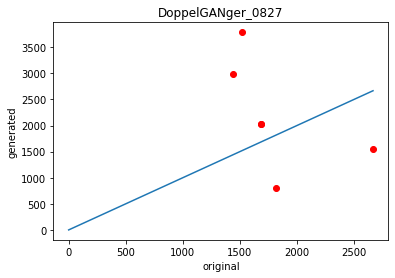

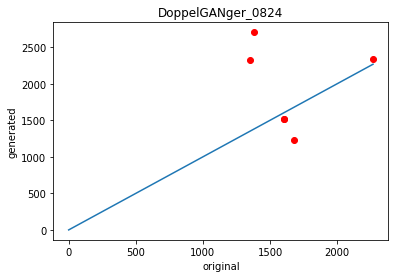

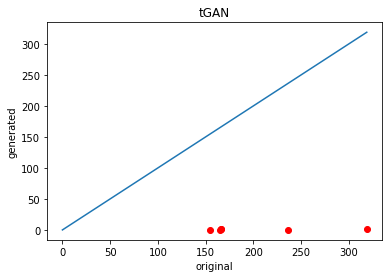

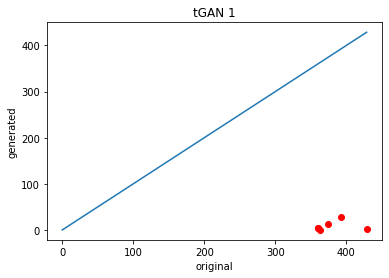

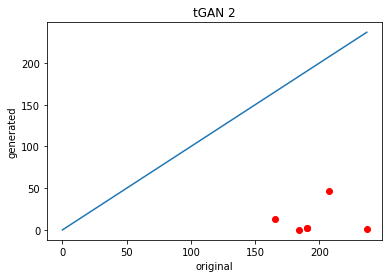

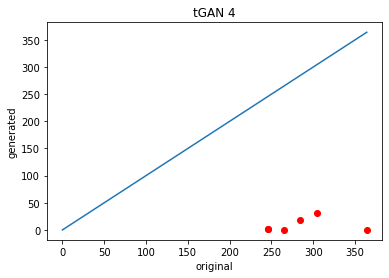

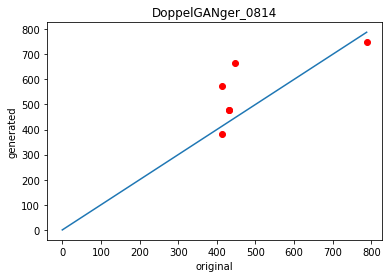

In [25]:
Scatter_TSTS_TRTR(com_t)

## Comment
We can see that models perform much better on synthetic data than the real data in the case of tGAN. This implies that the tGAN model may interpret the dependency between columns more simply (e.g. just take it as a linear relationship plus some noise) than it should be.  
DoppelGANger_0827 gives poor agreement.

## SRA measuring E Table

In [26]:
def SRA_TSTS_TRTR(E_table):
    df_dic = list(set(E_table.keys().get_level_values(0).tolist()))
    models = (E_table.index).tolist()
    l = len(df_dic)
    v_np = np.zeros(l)
    for n in range(l):
        key = df_dic[n]
        v_np[n] = SRA(E_table[key,'ori'],E_table[key,'gen'])
    display('SRA for E table')
    return pd.Series(v_np,index = df_dic)

In [27]:
sra_E = SRA_TSTS_TRTR(com_t)
display(sra_E)
sra_E.to_csv('csv_results/3.1 DWP/sra_E.csv')

'SRA for E table'

DoppelGANger_0827    0.200000
DoppelGANger_0824    0.400000
tGAN                 0.733333
tGAN 1               0.600000
tGAN 2               0.533333
tGAN 4               0.600000
DoppelGANger_0814    0.866667
dtype: float64

### Comment
* DoppelGANger 0814 preserves the ranking of performance of different models pretty well, but there are only five columns within it. 
* tGAN_1 also preserves the ranking best among the others.  
* DoppelGANger_0827 gives the worst ranking agreement.

## IV. SRA measuring the list of MSEs for each column predicition results, for the specified model and synthetic data generator

In [28]:
def SRA_Comparison(df_dic,models = ['LR','DTR','SVM','RFR','KNR1','KNR5'] ):
    '''
    The dataframe values are TSTSvsTRTR SRAs which are ranking values for the accuracy of every columns, for the index model which is trained and tested on the column dataset.
    '''
    l = len(df_dic)
    v_np = np.zeros((len(models),l))
    keys = list(df_dic.keys())
    for n in range(l):
        k = keys[n]
        P1 = Prediction(df_dic[k][0])
        P2 = Prediction(df_dic[k][1])
        for m in range(len(models)):
            model = models[m]
            v_np[m][n] = SRA(P1.Evaluation_MSE(model),P2.Evaluation_MSE(model))
    display('SRA for column rankings')
    return pd.DataFrame(v_np,index = models, columns = keys)

       
    

In [29]:
sra_c = SRA_Comparison(synthetic_num_dic)
display(sra_c)

/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

'SRA for column rankings'

,DoppelGANger_0814,DoppelGANger_0824,DoppelGANger_0827,tGAN,tGAN 1,tGAN 2,tGAN 4
LR,0.9,0.933333,0.933333,0.866667,0.866667,0.800000,0.800000
DTR,0.8,0.933333,0.866667,0.800000,0.933333,0.733333,0.733333
SVM,1.0,0.933333,0.933333,0.933333,0.800000,0.800000,0.800000
RFR,0.8,0.933333,0.933333,0.800000,0.933333,0.800000,0.733333
KNR1,0.7,0.933333,0.933333,0.800000,0.933333,0.866667,0.866667
KNR5,0.7,0.933333,0.933333,0.800000,0.933333,0.866667,0.866667


### Comment
There is no significant differences for different models or different synthetic data. The DoppelGANger_0824 gives the best result.

## V. Epsilon value tables

In [30]:
def Epsilon_Table(df_dic,models = ['LR','DTR','SVM','RFR','KNR1','KNR5'] ):
    '''
    The dataframe values are TSTSvsTRTR Epsilon values for the index model and column generator.
    '''
    from sklearn.metrics import mean_squared_error
    
    l = len(df_dic)
    v_np = np.zeros((len(models),l))
    keys = list(df_dic.keys())
    for n in range(l):
        k = keys[n]
        P1 = Prediction(df_dic[k][0])
        P2 = Prediction(df_dic[k][1])
        column_length = len((df_dic[k][0].keys()).tolist())
        for m in range(len(models)):
            model = models[m]
            v_np[m][n] = mean_squared_error(P1.Evaluation_MSE(model),P2.Evaluation_MSE(model))/column_length
    display('Epsilon value table')
    return pd.DataFrame(v_np,index = models, columns = keys)

In [31]:
EpsilonTable = Epsilon_Table(synthetic_num_dic)
EpsilonTable.to_csv('csv_results/3.1 DWP/EpsilonTable.csv')
display(EpsilonTable)

/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/xiaoyanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

'Epsilon value table'

,DoppelGANger_0814,DoppelGANger_0824,DoppelGANger_0827,tGAN,tGAN 1,tGAN 2,tGAN 4
LR,13869.773710,270130.459126,2.465901e+06,67110.243559,15292.673513,16785.159445,14564.783719
DTR,20661.484311,86719.662923,5.210234e+05,117342.820029,92690.698093,47202.073898,52007.315719
SVM,9125.250370,498701.071377,5.600245e+06,77844.632864,19800.589271,25844.496375,18627.479328
RFR,5633.825359,557797.123957,8.373117e+05,73879.024139,38305.473455,28469.530177,22829.114368
KNR1,2963.573847,81238.283357,1.131964e+05,53662.548522,19833.098348,31512.736201,18645.392540
KNR5,2963.573847,81238.283357,1.131964e+05,53662.548522,19833.098348,31512.736201,18645.392540


### Comment
TGAN1 and DoppelGANger_0827 perform worse than the others.